# APIs

In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Setup Data

import training data from .csv file

In [4]:
data = pd.read_csv('data/train.csv')
data.shape

(10189, 2)

import test data - problems for which the category is to be predicted

In [5]:
test_data = pd.read_csv('data/test.csv')
test_data.head()

,id,Question
0,0,b'Solve 0 = -i - 91*i - 1598*i - 64220 for i.\n'
1,1,Galperin G.A.\n\nA natural number $N$ is 999.....
2,2,Example 7 Calculate $\frac{1}{2 \sqrt{1}+\sqrt...
3,3,"If $A$, $B$, and $C$ represent three distinct ..."
4,4,2. Calculate $1+12+123+1234+12345+123456+12345...


In [6]:
test_data.shape

(3044, 2)

# Training data exploration

In [7]:
data.head()

,Question,label
0,A solitaire game is played as follows. Six di...,3
1,2. The school table tennis championship was he...,5
2,"Given that $x, y,$ and $z$ are real numbers th...",0
3,$25 \cdot 22$ Given three distinct points $P\l...,1
4,I am thinking of a five-digit number composed ...,5


check for missing values

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10189 entries, 0 to 10188
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  10189 non-null  object
 1   label     10189 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 159.3+ KB


Total samples for each class label

In [9]:
np.bincount(data.label)

array([2618, 2439, 1039,  368, 1712, 1827,  100,   86])

Classes 3, 6, and 7 have comparatively very low representation.

In [29]:
category = ['Algebra', 'Geometry', 'Calculus', 'Statistics', 'Number_theory', 'Combinatorics', 'Linear_Algebra', 'Abstract_Algebra']

## Creating train and test sets

In [21]:
text_train, text_test, y_train, y_test = train_test_split(np.array(data['Question']), np.array(data['label']), 
                                                          random_state=0, stratify=data['label'])

# Bag of Words

In [ ]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print(f'X_train: {repr(X_train)}')

X_train: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 189663 stored elements and shape (7641, 11213)>


Analyzing tokens

In [37]:
feature_names = vect.get_feature_names_out()
print(f'First 50 features:\n{feature_names[:200]}')

First 50 features:
['00' '000' '00000000' '000001' '0001' '00010000' '001' '0013' '002'
 '00214' '0025' '0026' '0028' '003' '004' '005' '006' '007' '008' '009'
 '01' '0101' '010512' '011' '011011' '011016' '012' '0123432123432' '013'
 '014' '017' '018' '019' '0197' '02' '020' '020922' '024' '025' '026'
 '027' '028' '03' '030' '030511' '030521' '030922' '031' '033' '03375'
 '035' '036' '039' '04' '040' '040914' '041214' '041224' '044' '045' '046'
 '049' '05' '050' '050936' '051' '052' '053' '056' '058' '05in' '06'
 '060723' '061021' '061045' '062' '0629' '063' '067' '068' '06inch' '07'
 '070' '070614' '071241' '071243' '076' '077' '0784' '0793' '08' '081224'
 '081244' '082' '084' '085' '088' '09' '090734' '090812' '091212' '092'
 '093' '095' '097' '098' '0_' '0_7' '0th'
 '0uucogtryj4ymjphfsk3oqihrqfut7usgclcbgasyhq' '10' '100' '1000' '10000'
 '100000' '1000000' '1000000000' '10000x' '10001' '100010001' '10003'
 '1000th' '1000x' '1001' '1001_b' '1001x' '1002' '10032' '1004' '1005'
 '1006

Since the dataset is of math problem statements, lot of tokens are just going to numbers or alphanumeric strings. Since these will be common across math problems, at first thought, they won't provide any value in differentiating between problem categories and should be excluded.

In [40]:
print(f'\nEvery 25th feature:\n{feature_names[::25]}')


Every 25th feature:
['00' '011016' '035' '062' '091212' '1001x' '1014' '1059' '10cm'
 '1111111111111111' '1153' '11y' '12199' '1238' '1275' '1300' '1350'
 '13970' '1434' '1481' '1510' '1565' '1616' '17005' '1792' '186' '1918'
 '1959' '198' '1997' '1尺' '2009x' '2020x'
 '2024_04_17_fd2d0ad36e2f3d54c0ceg' '2024_05_06_2befe970655743580344g'
 '2024_05_08_22585010b2534c7ab9ebg' '2025' '208' '211976' '221213'
 '231021' '23_b' '247' '2521' '260914' '273' '281012' '2925' '2bf' '2pq'
 '2y_2' '3032' '314' '325' '333x' '3452' '35th' '36th' '3808' '394' '3c'
 '4000' '40845' '421' '437' '4492' '4641' '481' '49560' '4l' '502' '51242'
 '53' '5490' '57' '5_b' '603' '630' '645' '66' '685' '6z' '725' '753'
 '784' '7x' '8192' '83x' '874' '8em' '9218' '955' '99' '9n' 'a8' 'a_7x'
 'ab_0c_0' 'about' 'accompany' 'acquainted' 'adding' 'aec' 'again'
 'aimeville' 'alexandru' 'alloy' 'alёna' 'an' 'angles' 'answered' 'apb'
 'applies' 'arc' 'armies' 'articles' 'assembled' 'asterisk' 'attempt'
 'automates' 'axial' 

From these, most tokens seem like subjects/nouns used to describe a problem statement.
I can also see some tokens denoting shapes, measures, concepts which will be useful in identifying the category.

In [42]:
print(f'Last 250 features:\n{feature_names[-250:]}')

Last 250 features:
['xz' 'xzcdqhggkfi' 'xzp0cepacei' 'y62' 'y_' 'y_0' 'y_1' 'y_2' 'y_3' 'y_4'
 'y_5' 'y_a' 'y_i' 'y_k' 'y_n' 'y_p' 'y_s' 'yann' 'yaoyao' 'yaps' 'yard'
 'yarn' 'yasmine' 'yatsenko' 'yaxis' 'yb' 'ybottom' 'year' 'years'
 'yellow' 'yequals' 'yes' 'yesterday' 'yet' 'yf_y' 'yi' 'yield' 'yielding'
 'yields' 'yingchun' 'yingying' 'ylimits' 'ymax' 'ymin' 'yndira' 'yolki'
 'york' 'you' 'young' 'younger' 'youngest' 'your' 'yourself' 'youth'
 'yscale' 'ystep' 'yt' 'ytop' 'yu' 'yuan' 'yugoslav' 'yuliawan' 'yuri'
 'yw'
 'yxr0ywnobwvudhmvoc8zl2iwzjnjmdaxnwewmtc1zgnjmtkwzmzlzmjlmgrlogrhyjk4nzczlnbuzw'
 'yy' 'yz' 'z_' 'z_0' 'z_1' 'z_2' 'z_3' 'z_4' 'z_j' 'z_jz_k' 'z_k' 'z_n'
 'za' 'zadaci' 'zadane' 'zadatak' 'zahl' 'zahlen' 'zahlenmäßig'
 'zalakomár' 'zanfirica' 'započne' 'zatvara' 'završava' 'završi' 'zebra'
 'zero' 'zeroes' 'zeros' 'zf' 'zhai' 'zhang' 'zhao' 'zhejiang' 'zhenhua'
 'zhenping' 'zhenya' 'zhouf' 'zigzag' 'zinc' 'zmey' 'znayka' 'zo' 'zoe'
 'zoka' 'zomr' 'zone' 'zoranel' 'zr

Finally, some tokens like 'yxr0ywnobwvudhmvoc8zl2iwzjnjmdaxnwewmtc1zgnjmtkwzmzlzmjlmgrlogrhyjk4nzczlnbuzw' may have been created as a result of Vectorization, and may appear only once. We also have some tokens which appear to be in Russian and Chinese. I will ignore them for now.

In [72]:
sel_rows = np.where(
    X_train[:, vect.vocabulary_.get("yxr0ywnobwvudhmvoc8zl2iwzjnjmdaxnwewmtc1zgnjmtkwzmzlzmjlmgrlogrhyjk4nzczlnbuzw")].toarray().ravel()>0)
text_train[sel_rows]

array(['In the diagram below, $BP$ bisects $\\angle ABC$, $CP$ bisects $\\angle BCA$, and $PQ$ is perpendicular to $BC$. If $BQ\\cdot QC=2PQ^2$, prove that $AB+AC=3BC$.\n[img]https://services.artofproblemsolving.com/download.php?id=YXR0YWNobWVudHMvOC8zL2IwZjNjMDAxNWEwMTc1ZGNjMTkwZmZlZmJlMGRlOGRhYjk4NzczLnBuZw==&rn=VlRSTUMgMjAwNi5wbmc=[/img]'],
      dtype=object)

# Baseline Model

## Logistic Regression

In [79]:
pipe = make_pipeline(CountVectorizer(),
                     LogisticRegression(max_iter=1000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
strat_cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=strat_cv, scoring='f1_micro')
grid.fit(text_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100]},
             scoring='f1_micro')

In [82]:
print(f'Best cross-validation score (f1-micro): {grid.best_score_:.3f}')

Best cross-validation score (f1-micro): 0.769


The baseline CV score is 77%.

In [89]:
y_pred = grid.best_estimator_.predict(text_train)
print(f'Classification report:\n{classification_report(y_train, y_pred, digits=3)}')

Classification report:
              precision    recall  f1-score   support

           0      0.841     0.930     0.883      1963
           1      0.965     0.955     0.960      1829
           2      0.854     0.797     0.825       779
           3      0.984     0.906     0.943       276
           4      0.865     0.889     0.877      1284
           5      0.937     0.872     0.903      1370
           6      1.000     0.347     0.515        75
           7      0.912     0.800     0.852        65

    accuracy                          0.898      7641
   macro avg      0.920     0.812     0.845      7641
weighted avg      0.900     0.898     0.896      7641



There seems to be a good balance between precision and recall for all the classes except 'class 6'. 
For Class 6, there are 0 FP but high FN - predicting samples from Class 6 as other class. 

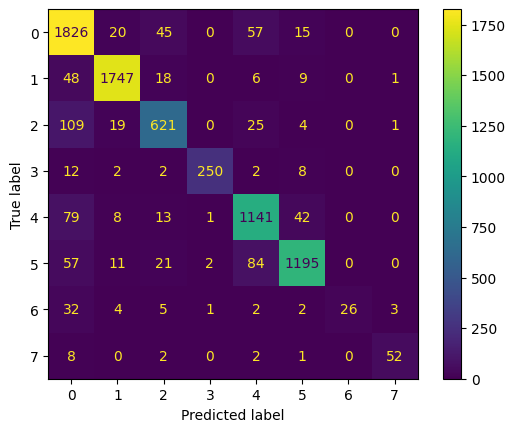

In [103]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)

In [117]:
print(f'ROC AUC score: {roc_auc_score(y_train, grid.best_estimator_.predict_proba(text_train), multi_class='ovr', average='micro'):.3f}')

ROC AUC score: 0.992


## Naive Bayes - Multinomial

In [127]:
pipe = make_pipeline(CountVectorizer(),
                     MultinomialNB())
param_grid = {'multinomialnb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
strat_cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(pipe, param_grid=param_grid, cv=strat_cv, scoring='f1_micro')
grid.fit(text_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [0.001, 0.01, 0.1, 1, 10,
                                                  100]},
             scoring='f1_micro')

In [128]:
print(f'Best CV score: {grid.best_score_:.3f}')

Best CV score: 0.725
